Description of the dataset, which includes but is not limited to its size and features

# Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os
from tqdm import tqdm
import random
# from collections import Counter

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.utils.rnn as rnn_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
# Load the train.csv file
train_df = pd.read_csv('/content/drive/MyDrive/COMP4211/shuffled_A_B_relation_train.csv')
train_df

,EventA,EventB,relation
0,PersonX causes trouble,"['Is arrested', 'Thrown in jail']",xEffect
1,PersonX drops off the radar,"['has peace an quiet', 'gets more sleep']",xEffect
2,PersonX starts the fire,"['to light a match', 'to pour gasoline everywh...",xNeed
3,PersonX attends to PersonY's duties,"['to hear thanks', 'keep helping person']",xWant
4,PersonX lets PersonY go,"['sad, but helpful']",xReact
...,...,...,...
319770,PersonX closes PersonY's doors,"['helpful', 'generous']",xReact
319771,PersonX has a pizza party,"['thank personx', 'help clean up']",oWant
319772,PersonX invites PersonY to PersonX's house,['like he made a friend'],xReact
319773,PersonX blows PersonY's nose,"['to protest', 'to thank PersonX']",oWant


In [ ]:
# Take the first 100000 data points
size = 100000
# train_df_subset = train_df.sample(n=size, random_state=42)
train_df_subset = train_df # take all data instead

# Split the subset into training and validation sets (4:1 ratio)
train_data, val_data = train_test_split(train_df_subset, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Training data size: 255820
Validation data size: 63955


In [ ]:
train_data

,EventA,EventB,relation
175563,PersonX gives PersonY a time,"['for discussion', 'to speak', 'to meet']",xIntent
116446,PersonX texts back,"['responsive', 'kind']",xAttr
264520,PersonX has to call the fire department,"['to look for the phone', 'to see a fire', 'to...",xNeed
251547,PersonX sees one,"['to go to it', 'to tell someone he saw one']",xWant
303551,PersonX helps PersonY in every way,"['considerate', 'friendly', 'dedicated']",xAttr
...,...,...,...
119879,PersonX tests every ___,"['Year', 'assignment']",xWant
259178,PersonX regulates PersonY's ___ according,['beholden'],oReact
131932,PersonX meets ___ at the door,"['PersonX says hello', 'PersonX signs for a pa...",xEffect
146867,PersonX gives ___ to PersonX's parents,"['to check the report card', 'to talk to Perso...",oWant


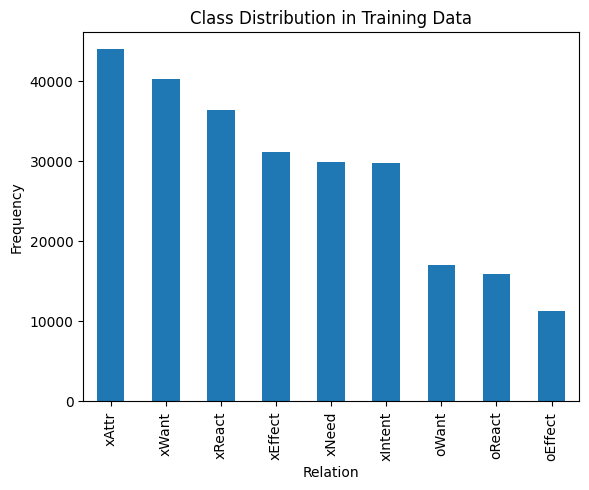

In [ ]:
relation_counts = train_data['relation'].value_counts()
relation_counts.plot(kind='bar')
plt.xlabel('Relation')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

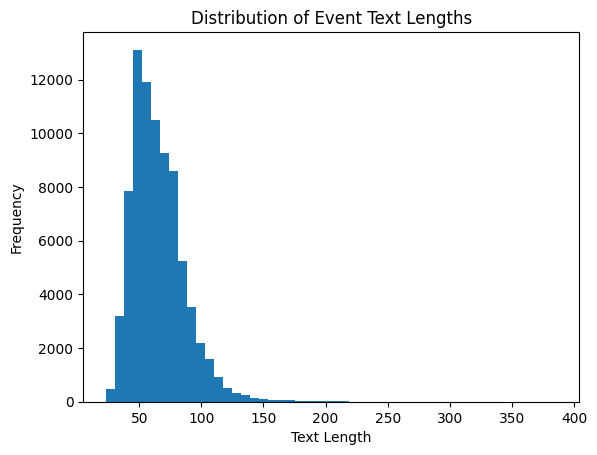

In [ ]:
# 检查输入事件的文本长度分布
train_data['text_length'] = train_data['EventA'].apply(len) + train_data['EventB'].apply(len)
train_data['text_length'].plot(kind='hist', bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Event Text Lengths')
plt.show()

In [ ]:
train_data["relation"].unique()

array(['oWant', 'oEffect', 'xNeed', 'xAttr', 'xWant', 'xReact', 'xEffect',
       'xIntent', 'oReact'], dtype=object)

Define Custom Dataset Class

In [ ]:
# Step 1: Construct the relation vocabulary
relations = train_data['relation'].unique()
relation_vocab = {relation: idx for idx, relation in enumerate(relations)}
print("Relation Vocabulary:", relation_vocab)  # 查看关系与索引的映射

Relation Vocabulary: {'oWant': 0, 'oEffect': 1, 'xNeed': 2, 'xAttr': 3, 'xWant': 4, 'xReact': 5, 'xEffect': 6, 'xIntent': 7, 'oReact': 8}


In [ ]:
# from collections import Counter

# # Step 2: Construct the event vocabulary
# # Get all event texts
# all_text = train_data['EventA'].tolist() + train_data['EventB'].tolist()

# # Tokenize the text
# all_tokens = []
# for text in all_text:
#     tokens = text.split()
#     all_tokens.extend(tokens)

# # Count token frequencies
# token_counter = Counter(all_tokens)

# # Create the vocabulary: Use idx + 1 to reserve 0 for padding
# vocab = {word: idx + 1 for idx, (word, _) in enumerate(token_counter.items())}
# vocab['<unk>'] = 0  # Special token for unknown words

# # Check vocabulary size
# print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 42147


## Resampling (will not use)

SMOTE 不适用于文本数据，因为文本数据的特征空间不适合进行插值。

In [ ]:
from imblearn.over_sampling import SMOTE

# 将训练数据转换为 NumPy 数组
train_features_np = preprocess_input(train_data, vocab)
train_targets_np = train_data['relation'].map(relation_vocab).values

# 使用 SMOTE 重采样
smote = SMOTE()
train_features_resampled, train_targets_resampled = smote.fit_resample(train_features_np, train_targets_np)

# 将重采样后的数据转换为 TensorFlow Dataset
train_dataset_resampled = tf.data.Dataset.from_tensor_slices((train_features_resampled, train_targets_resampled))

124065


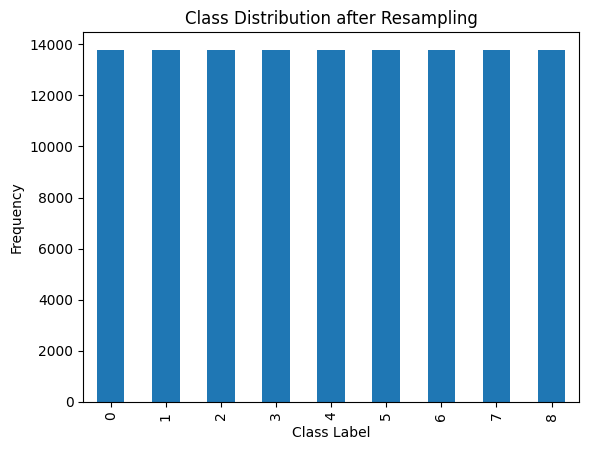

In [ ]:
resampled_targets_series = pd.Series(train_targets_resampled)
print(len(resampled_targets_series))

# plot out the new resampled data
resampled_targets_series.value_counts().plot(kind='bar')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution after Resampling')
plt.show()

In [ ]:
print(train_dataset_resampled)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(15,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Data Augmentation

In [ ]:
import nltk
from nltk.corpus import wordnet

# 下载 WordNet 数据
nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence, n=2):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            if synonym != random_word:
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
augmented_data = []

for _, row in train_data.iterrows():
    event_a = row['EventA']
    event_b = row['EventB']
    relation = row['relation']

    # 原始数据
    augmented_data.append({'EventA': event_a, 'EventB': event_b, 'relation': relation})

    # 对 EventA 和 EventB 分别进行数据增强
    augmented_event_a = synonym_replacement(event_a)
    augmented_event_b = synonym_replacement(event_b)

    # 添加增强后的数据
    augmented_data.append({'EventA': augmented_event_a, 'EventB': event_b, 'relation': relation})
    augmented_data.append({'EventA': event_a, 'EventB': augmented_event_b, 'relation': relation})
    augmented_data.append({'EventA': augmented_event_a, 'EventB': augmented_event_b, 'relation': relation})

# 转换为 DataFrame
augmented_df = pd.DataFrame(augmented_data)

In [ ]:
# 获取所有文本
all_text = augmented_df['EventA'].tolist() + augmented_df['EventB'].tolist()

# 分词
all_tokens = []
for text in all_text:
    tokens = text.split()
    all_tokens.extend(tokens)

# 统计词频
token_counter = Counter(all_tokens)

# 创建词汇表
vocab = {word: idx + 1 for idx, (word, _) in enumerate(token_counter.items())}
vocab['<unk>'] = 0  # 未知词
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 76488


## Data -> tf format

In [ ]:
# Step 3: Prepare the dataset using TensorFlow
class AtomicDataset(tf.data.Dataset):
    def __new__(cls, dataframe, vocab, relation_vocab, max_length=15):
        # Convert the dataframe into sequences of indices
        original_features_list = []
        features_list = []
        targets_list = []

        for _, row in dataframe.iterrows():
            # Concatenate EventA and EventB as the input features
            original_features = row['EventA'] + " " + row['EventB']
            features = original_features
            tokens = features.split()

            # Convert tokens to indices using vocab
            feature_indices = [vocab.get(word, 0) for word in tokens]  # Use 0 if word is not in vocab (<unk>)

            # Padding or trimming to ensure consistent length
            if len(feature_indices) > max_length:
                feature_indices = feature_indices[:max_length]  # Trim to max_length
            else:
                feature_indices += [0] * (max_length - len(feature_indices))  # Pad with zeros

            # Append features and target to the list
            original_features_list.append(original_features)
            features_list.append(feature_indices)
            targets_list.append(relation_vocab[row['relation']])

        # Convert lists to numpy arrays
        original_features_np = np.array(original_features_list, dtype=np.str_)
        features_np = np.array(features_list, dtype=np.int32)
        targets_np = np.array(targets_list, dtype=np.int32)

        # Create a TensorFlow dataset
        # return tf.data.Dataset.from_tensor_slices((original_features_np, features_np, targets_np)) # only used to check before training, not used anymore
        return tf.data.Dataset.from_tensor_slices((features_np, targets_np))

In [ ]:
# Step 4: Create training and validation datasets
train_data_augmented, val_data_augmented = train_test_split(augmented_df, test_size=0.2, random_state=42)

train_dataset = AtomicDataset(train_data_augmented, vocab, relation_vocab)
val_dataset = AtomicDataset(val_data_augmented, vocab, relation_vocab)

# Set batch size
batch_size = 256

# Shuffle and batch the training dataset, plus caching the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(train_data_augmented)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

testing dataset

In [ ]:
# Check 1 sample from the dataset
# with original feature debugging is commented out as input dim is 2 but not 3
# for i, (original_features, features, target) in enumerate(train_dataset.take(1)):
    # original_features_decoded = [feat.decode('utf-8') if isinstance(feat, bytes) else feat for feat in original_features.numpy()]
    # print(f"Original Features (Index {i}): {' '.join(original_features_decoded)}")
    # print(f"Encoded Features (Index {i}): {features.numpy()}")
    # print(f"Target (Index {i}): {target.numpy()}")

for i, (features, target) in enumerate(train_dataset.take(1)):
    print(f"Features shape: {features.shape}")
    print(f"Target shape: {target.shape}")
    print(f"Features (Index {i}): {features.numpy()}")
    print(f"Target (Index {i}): {target.numpy()}")

Features shape: (256, 15)
Target shape: (256,)
Features (Index 0): [[   1 1145   27 ...    0    0    0]
 [   1  990   29 ...    0    0    0]
 [   1  176   14 ...    0    0    0]
 ...
 [   1  135 4898 ...    0    0    0]
 [   1 1147   27 ...    0    0    0]
 [   1   11 6078 ... 1559 6351  146]]
Target (Index 0): [7 3 5 4 3 7 2 7 5 1 4 3 5 5 6 7 0 6 4 1 7 6 4 7 6 1 1 3 5 1 6 8 4 4 2 4 6
 4 7 0 0 3 0 4 4 5 3 3 1 6 5 7 0 5 4 3 4 3 6 2 8 7 3 3 3 3 1 1 7 0 6 6 8 4
 7 2 2 8 5 2 3 4 6 4 8 3 4 4 4 6 6 5 2 2 7 4 3 3 4 6 0 5 3 7 3 5 7 0 0 3 3
 6 1 7 7 3 4 3 5 5 2 3 3 4 3 6 5 2 4 5 7 4 6 0 2 6 4 4 1 2 8 2 2 6 2 5 3 6
 2 0 5 2 6 6 4 6 3 6 7 3 8 8 8 4 0 3 7 6 7 3 6 3 4 3 2 5 2 5 2 8 1 1 6 0 2
 7 6 2 6 4 2 5 3 7 3 2 3 5 2 6 6 5 3 6 4 4 7 4 2 1 2 0 6 3 3 6 6 5 4 2 2 6
 4 3 0 2 2 2 0 5 3 4 3 5 5 5 8 3 5 1 2 6 7 7 4 6 6 4 2 7 0 5 0 5 7 4]


# Training

Define LSTM Model

In [ ]:
# Step 5: Define LSTM Model
vocab_size = len(vocab) + 1  # Add 1 to include <pad> or <unk> token
embedding_dim = 64           # Dimension of word embeddings
hidden_dim = 256             # Hidden dimension of LSTM
output_dim = len(relation_vocab)  # Output dimension matches the number of relation classes

# Define LSTM model using Keras Sequential API
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=15),
    layers.LSTM(hidden_dim, return_sequences=False, dropout=0.5),
    layers.BatchNormalization(), # enhanse convergense
    layers.Dense(256, activation='relu'), # Added an extra Dense layer]
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(output_dim, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 6: Train the Model
epochs = 5  # Number of epochs for training

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # Use validation dataset during training
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1  # Display progress bar during training
)

Epoch 1/5
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 910s 282ms/step - accuracy: 0.6711 - loss: 0.9270 - val_accuracy: 0.8190 - val_loss: 0.4927
Epoch 2/5
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 929s 290ms/step - accuracy: 0.8301 - loss: 0.4753 - val_accuracy: 0.8558 - val_loss: 0.4007
Epoch 3/5
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 900s 281ms/step - accuracy: 0.8561 - loss: 0.3977 - val_accuracy: 0.8659 - val_loss: 0.3618
Epoch 4/5
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 946s 288ms/step - accuracy: 0.8708 - loss: 0.3544 - val_accuracy: 0.8765 - val_loss: 0.3222
Epoch 5/5
3198/3198 ━━━━━━━━━━━━━━━━━━━━ 906s 283ms/step - accuracy: 0.8803 - loss: 0.3242 - val_accuracy: 0.8880 - val_loss: 0.2974


In [ ]:
# Step 7: Save the trained model
model_save_path = '/content/drive/MyDrive/COMP4211/trained_lstm_model.h5'  # You can specify any path you like
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/COMP4211/trained_lstm_model.h5


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('trained_lstm_model.h5')

# Prediction

In [ ]:
def preprocess_input(dataframe, vocab, max_length=15):
    features_list = []

    for _, row in dataframe.iterrows():
        # Concatenate EventA and EventB
        features = row['EventA'] + " " + row['EventB']
        tokens = features.split()

        # Convert tokens to indices
        feature_indices = [vocab.get(word, 0) for word in tokens]

        # Pad or truncate sequences
        if len(feature_indices) > max_length:
            feature_indices = feature_indices[:max_length]
        else:
            feature_indices += [0] * (max_length - len(feature_indices))

        features_list.append(feature_indices)

    # Convert to NumPy array
    features_np = np.array(features_list, dtype=np.int32)
    return features_np

In [ ]:
for i in range(5):
    # Step 1: Randomly select one data point from train_df[100000:] # size = 100000
    random_index = random.randint(0, len(train_df) - 1)
    random_sample = train_df.iloc[random_index:random_index + 1]

    # Step 2: Preprocess the selected input using the function you defined earlier
    input_features_np = preprocess_input(random_sample, vocab)

    # Step 3: Get the correct output label for comparison
    correct_relation = random_sample['relation'].values[0]

    # Step 4: Make the prediction
    predictions = model.predict(input_features_np)

    # Step 5: Convert prediction to class label
    predicted_class = np.argmax(predictions, axis=-1)[0]  # Since it's only one input
    inverse_relation_vocab = {v: k for k, v in relation_vocab.items()}
    predicted_label = inverse_relation_vocab[predicted_class]

    # Step 6: Display the input, correct output, and predicted output
    print("Input Features:", random_sample['EventA'].values[0], "+", random_sample['EventB'].values[0])
    print("Correct Output:", correct_relation)
    print("Predicted Output:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Features: PersonX teaches ___ for years + ['devoted', 'enthusiastic']
Correct Output: xAttr
Predicted Output: xAttr
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Input Features: PersonX puts PersonY's arm around PersonY + ['has body contact with PersonY', 'gets attached to PersonY']
Correct Output: xEffect
Predicted Output: xEffect
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input Features: PersonX reads PersonY article + ['glad that he could help person']
Correct Output: xReact
Predicted Output: xReact
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input Features: PersonX petitions the ___ for a redress + ['to start a blog', 'to protest']
Correct Output: xNeed
Predicted Output: xNeed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Input Features: PersonX sees a car + ['go to ride', 'to buy a new car']
Correct Output: xEffect
Predicted Output: xWant


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Make predictions on the validation dataset
val_features = []
val_labels = []

for features, label in val_dataset:
    val_features.append(features.numpy())
    val_labels.append(label.numpy())

# Convert lists to numpy arrays
val_features_np = np.concatenate(val_features, axis=0)
val_labels_np = np.concatenate(val_labels, axis=0)

# Get predictions
predictions = model.predict(val_features_np)
predicted_labels = np.argmax(predictions, axis=-1)

# Step 2: Generate confusion matrix
cm = confusion_matrix(val_labels_np, predicted_labels)

6396/6396 ━━━━━━━━━━━━━━━━━━━━ 110s 17ms/step


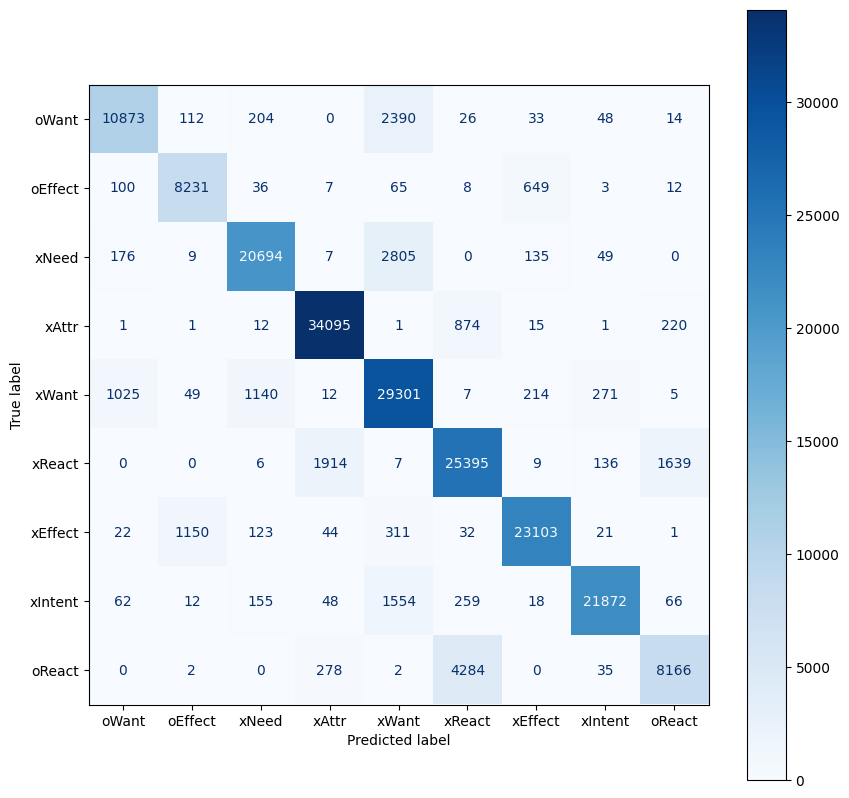

In [ ]:
# Step 3: Plot confusion matrix
# %matplotlib inline
# plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(relation_vocab.keys()))
disp.plot(cmap=plt.cm.Blues)

# Show the confusion matrix
fig = disp.figure_
fig.set_size_inches(10, 10)  # 调整图表的大小
plt.show()

In [ ]:
# 获取类别数
num_classes = cm.shape[0]

# 初始化 Precision 和 Recall 列表
precision = []
recall = []

# 计算每个类别的 Precision 和 Recall
for i in range(num_classes):
    TP = cm[i, i]  # 对角线元素
    FP = np.sum(cm[:, i]) - TP  # 列上的所有元素之和减去 TP
    FN = np.sum(cm[i, :]) - TP  # 行上的所有元素之和减去 TP

    precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)

# 转换为百分比并打印结果
precision_percent = [f"{p * 100:.2f}%" for p in precision]
recall_percent = [f"{r * 100:.2f}%" for r in recall]

# 打印每个类别的 Precision 和 Recall
labels = ['xIntent', 'xEffect', 'xWant', 'xAttr', 'xNeed', 'xReact', 'oWant', 'oEffect', 'oReact']
for i, label in enumerate(labels):
    print(f"{label}: Precision = {precision_percent[i]}, Recall = {recall_percent[i]}")

xIntent: Precision = 88.69%, Recall = 79.36%
xEffect: Precision = 86.04%, Recall = 90.34%
xWant: Precision = 92.51%, Recall = 86.68%
xAttr: Precision = 93.65%, Recall = 96.81%
xNeed: Precision = 80.42%, Recall = 91.50%
xReact: Precision = 82.22%, Recall = 87.25%
oWant: Precision = 95.56%, Recall = 93.13%
oEffect: Precision = 97.49%, Recall = 90.96%
oReact: Precision = 80.67%, Recall = 63.96%


# Error Analysis

In [ ]:
# Assuming you have the validation dataset and trained model
val_predictions = model.predict(val_dataset)  # Get predictions for validation dataset
val_predictions_classes = np.argmax(val_predictions, axis=1)  # Get predicted class labels

# Get the true labels from the validation dataset
val_features = []
val_targets = []
for features, targets in val_dataset:
    val_features.extend(features.numpy())
    val_targets.extend(targets.numpy())

val_features = np.array(val_features)
val_targets = np.array(val_targets)

# Identify misclassified examples
misclassified_indices = np.where(val_predictions_classes != val_targets)[0]
misclassified_features = val_features[misclassified_indices]
misclassified_true_labels = val_targets[misclassified_indices]
misclassified_predicted_labels = val_predictions_classes[misclassified_indices]

# Create a DataFrame with the misclassified examples
error_analysis_df = pd.DataFrame({
    'features': list(misclassified_features),
    'true_label': misclassified_true_labels,
    'predicted_label': misclassified_predicted_labels
})

# If your features are sequences, you may also want to decode them back into readable strings
def decode_features(features, vocab):
    reverse_vocab = {idx: word for word, idx in vocab.items()}
    return ' '.join([reverse_vocab.get(idx, '<unk>') for idx in features if idx != 0])

# Example: Decode features for error analysis
error_analysis_df['decoded_features'] = error_analysis_df['features'].apply(lambda x: decode_features(x, vocab))

800/800 ━━━━━━━━━━━━━━━━━━━━ 63s 78ms/step


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
!pip install ace_tools
!pip show ace_tools

Name: ace_tools
Version: 0.0
Summary: A placeholder empty package
Home-page: 
Author: Paul McMillan
Author-email: paul@mcmillan.ws
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [164]:
# Create a reverse mapping from indices to relation names
index_to_relation = {v: k for k, v in relation_vocab.items()}

# Apply the reverse mapping to 'true_label' and 'predicted_label' columns
error_analysis_df['true_label_name'] = error_analysis_df['true_label'].map(index_to_relation)
error_analysis_df['predicted_label_name'] = error_analysis_df['predicted_label'].map(index_to_relation)

In [165]:
# Display the DataFrame for qualitative inspection
from IPython.display import display
display(error_analysis_df)

,features,true_label,predicted_label,decoded_features,error_category,true_label_name,predicted_label_name
0,"[1, 48, 334, 94, 4, 164, 12479, 6929, 22, 9576...",6,1,"PersonX is hit by a car ['dies', 'screams in p...",Missing Features or Ambiguous,xEffect,oEffect
1,"[1, 2012, 29, 1130, 7523, 0, 0, 0, 0, 0, 0, 0,...",8,5,PersonX publishes ___ online ['interested'],Missing Features or Ambiguous,oReact,xReact
2,"[1, 2, 29, 4, 3502, 6334, 1182, 4, 610, 9297, ...",7,4,PersonX gives ___ a massage ['to beryllium a g...,Missing Features or Ambiguous,xIntent,xWant
3,"[1, 34, 27, 28, 13741, 15300, 0, 0, 0, 0, 0, 0...",8,3,"PersonX takes PersonY's baby ['delighted', 'fr...",Missing Features or Ambiguous,oReact,xAttr
4,"[1, 266, 1993, 35, 451, 52723, 0, 0, 0, 0, 0, ...",8,5,"PersonX remains until PersonX's death ['sad,cr...",Missing Features or Ambiguous,oReact,xReact
...,...,...,...,...,...,...,...
22921,"[1, 197, 4, 198, 1025, 7226, 280, 6448, 21247,...",2,4,"PersonX buys a new truck ['save up money', 'sh...",Missing Features or Ambiguous,xNeed,xWant
22922,"[1, 168, 1590, 12, 1591, 7294, 28215, 0, 0, 0,...",3,5,"PersonX be allergic to peanuts ['scared', 'itc...",Missing Features or Ambiguous,xAttr,xReact
22923,"[1, 729, 12, 35, 313, 6334, 5946, 4, 7012, 632...",0,4,PersonX talks to PersonX's mother ['to build a...,Missing Features or Ambiguous,oWant,xWant
22924,"[1, 653, 137, 7007, 12415, 0, 0, 0, 0, 0, 0, 0...",3,5,"PersonX finally brand ['accomplished', 'comple...",Missing Features or Ambiguous,xAttr,xReact


In [ ]:
# Categorize errors based on observed patterns
def categorize_error(row):
    if row['true_label'] in ['Class_A', 'Class_B']:  # Use actual classes that might be ambiguous
        return 'Ambiguous Labeling'
    elif row['predicted_label'] in ['Class_X', 'Class_Y']:  # Use actual classes that could have noisy labels
        return 'Noisy Label'
    else:
        return 'Missing Features or Ambiguous'

# Apply the categorization to each row in the DataFrame
error_analysis_df['error_category'] = error_analysis_df.apply(categorize_error, axis=1)

# Display the first few rows of categorized errors for qualitative inspection
display(error_analysis_df[['true_label', 'predicted_label', 'error_category']].head(10))

# Count the number of errors in each category
error_category_counts = error_analysis_df['error_category'].value_counts()

,true_label,predicted_label,error_category
0,6,1,Missing Features or Ambiguous
1,8,5,Missing Features or Ambiguous
2,7,4,Missing Features or Ambiguous
3,8,3,Missing Features or Ambiguous
4,8,5,Missing Features or Ambiguous
5,7,0,Missing Features or Ambiguous
6,6,1,Missing Features or Ambiguous
7,3,8,Missing Features or Ambiguous
8,8,5,Missing Features or Ambiguous
9,2,4,Missing Features or Ambiguous


In [ ]:
error_analysis_df["error_category"].unique()

array(['Missing Features or Ambiguous'], dtype=object)

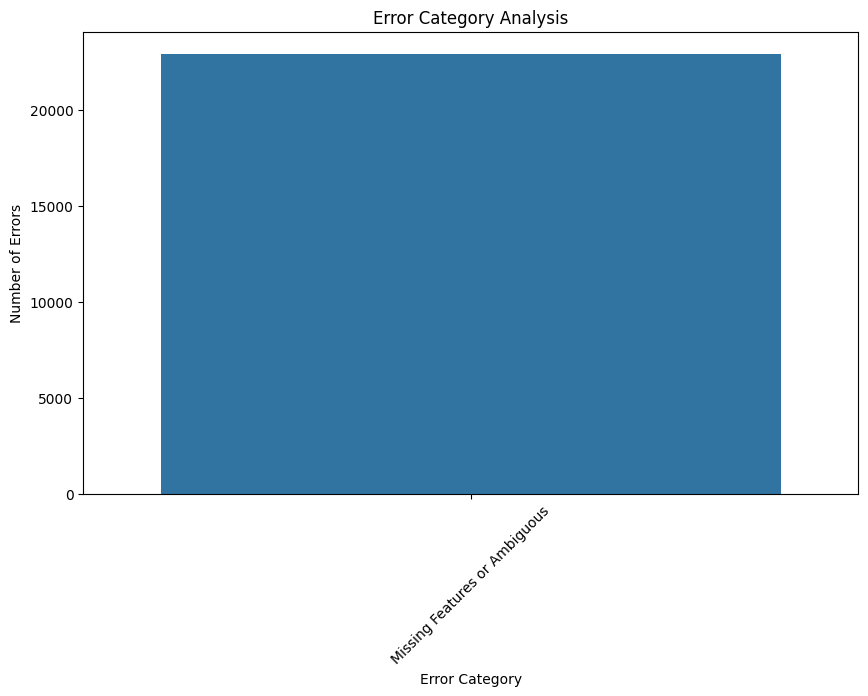

In [ ]:
# Plot the error categories
plt.figure(figsize=(10, 6))
sns.barplot(x=error_category_counts.index, y=error_category_counts.values)
plt.xlabel('Error Category')
plt.ylabel('Number of Errors')
plt.title('Error Category Analysis')
plt.xticks(rotation=45)
plt.show()